In [1]:
from gensim.models import Word2Vec,FastText
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from tensorflow import keras
import re
from nltk.stem import WordNetLemmatizer
from word2number import w2n



from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding,LSTM,Dense,Input,Bidirectional,Attention,Concatenate,TimeDistributed

pd.set_option("display.max_columns", None)
np.random.seed(42)
tf.random.set_seed(42)

MAX_LEN = 45


In [2]:
df_dev = pd.read_json("dataset/PIZZA_dev.json", lines=True,) 

In [3]:
main_train = pd.read_json("dataset/PIZZA_train.json", lines=True,)
df_dev = pd.read_json("dataset/PIZZA_dev.json", lines=True,)

In [4]:
df_train = main_train.sample(500000).drop_duplicates(inplace=False)

In [5]:
CONTRACTIONS = {
    "n't": "not",
    "'s": "is",
    "'re": "are",
    "'m": "am",
    "'ll": "will",
    "'ve": "have",
    "'d": "would",
    "'em": "them",
    "'all": "all",
    "'cause": "because",
    "'clock": "oclock",
    "'tis": "it is",
    "'twas": "it was",
    "'tween": "between",
    "'twere": "it were",
    "'twould": "it would",
    "'twixt": "betwixt",
    "'twill": "it will",
    "'til": "until",
    "'bout": "about",
    "'cept": "except",
    "'cos": "because",
    "'fore": "before",
    "'round": "around",
    "'n'": "and",
    "'neath": "beneath",
    "'nother": "another",
    "'nuff": "enough",
}
negation_words = {
    "no",
    "not",
    "none",
    "never",
    "without",
    "avoid",
    "neither",
    "nor",
    "hate",
    "hold",
}
pizza = {"pizza", "pizzas", "pie", "pies"}

stop_negation_words = {"and"}
stop_words = set(stopwords.words("english"))
stop_words = stop_words - negation_words - stop_negation_words - {'all' , 'a','an' , 'can'}
stop_words.update({"would", "like", "get", "want", "order" , "please" , 'could' , 'prefer' ,
                    'handle' , 'take' , 'bring' , 'need' , 'make' , 'love', 'let', 'absolutely',
                    "arrange",'today' , 'tommorow','add' , 'thank' , 'thanks' , 'tonight' , 'right' , 'left'})
stop_words.update(pizza)

lemmatizer = WordNetLemmatizer()  # WordNet Lemmatizer


In [6]:
def expnad_abb2(text):

    pattern = re.compile(
        r"(" + "|".join(re.escape(key) for key in CONTRACTIONS.keys()) + r")"
    )
    expanded_text = pattern.sub(lambda x: " " + CONTRACTIONS[x.group()], text)
    return expanded_text


In [7]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

In [8]:
relation_tags = {
    'O':0,
    'B-Pizza':1, 'I-Pizza':2,
    'B-Drink':3, 'I-Drink':4,
}

In [9]:
pizza_order_regex = re.compile(r'\(PIZZAORDER\b\s*((?:[^()]*|\((?:[^()]*|\([^()]*\))*\))*)\)')
drink_order_regex = re.compile(r'\(DRINKORDER\b\s*((?:[^()]*|\((?:[^()]*|\([^()]*\))*\))*)\)')

clean_regex = re.compile(r'[A-Z]+_?[A-Z]*|\(|\)')
# clean_regex = re.compile(r'\(NUMBER |\(SIZE |\(TOPPING |\(COMPLEX_TOPPING |\(NOT |\(STYLE |\(DRINKTYPE |\(VOLUME |\(CONTAINERTYPE |\s+\)\s+')

In [10]:

def standardize_numbers(text):
    text = text.split()
    for i,w in enumerate(text):
        try:
            text[i] = str(w2n.word_to_num(w))
        except:
            if text[i] == 'a' or text[i] == 'an':
                text[i] = '1'
            else:
                text[i] = w
    return " ".join(text)


In [11]:
lemmatizer = WordNetLemmatizer()

def lemma(text):
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text] 
    return " ".join(text)

In [12]:
df_train['train.SRC'] = df_train['train.SRC'].apply(lambda x: expnad_abb2(x))
df_train['train.SRC'] = df_train['train.SRC'].apply(lambda x: remove_stopwords(x))
# df_train['train.SRC'] = df_train['train.SRC'].apply(lambda x: standardize_numbers(x))
# df_train['train.SRC'] = df_train['train.SRC'].apply(lambda x: lemma(x))

In [13]:
df_train['train.TOP'] = df_train['train.TOP'].apply(lambda x: expnad_abb2(x))
df_train['train.TOP'] = df_train['train.TOP'].apply(lambda x: remove_stopwords(x))

In [14]:
def pizza_order_parser(src,top):
    labels = ['O' for i in range(len(src.split()))]
    src = src.split()
    pizza_orders = pizza_order_regex.findall(top)
    pizza_orders = [clean_regex.sub("", order) for order in pizza_orders]
    pizza_orders = [order.split() for order in pizza_orders]
    # pizza_orders = [re.split(r'\s+|_', order) for order in pizza_orders]
    # pizza_orders = [[word.lower() for word in order if len(word) > 0] for order in pizza_orders]
    for order in pizza_orders:
        # order = [word.lower() for word in order]
        try:
            start_index = src.index(order[0])
        except:
            order = order[1:]
            start_index = src.index(order[0])

        while labels[start_index] != 'O':
            # try:
            start_index = src.index(order[0],start_index+1)
            # except:
                # break
        labels[start_index] = "B-Pizza"
        for word in order[1:]:
            try:
                labels[src.index(word, start_index + 1)] = "I-Pizza"
            except: 
                continue
        
    return " ".join(labels)   

# src = x_dev[0]
# # src = expnad_abb2(src)
# # src = remove_stopwords(src)
# # src = standardize_numbers(src)
# # src = lemma(src)
# print(src)
# top = y_dev[0]
# 
# print(pizza_order_parser(src,top))

In [15]:
def drink_order_parser(src,top,labels):
    # labels = ['O' for i in range(len(src.split()))]
    labels = labels.split()
    src = src.split()
    drink_orders = drink_order_regex.findall(top)
    drink_orders = [clean_regex.sub("", order) for order in drink_orders]
    drink_orders = [order.split() for order in drink_orders]
    # drink_orders = [re.split(r'\s+|_', order) for order in drink_orders]
    # drink_orders = [[word.lower() for word in order if len(word) > 0] for order in drink_orders]
    for order in drink_orders:
        # order = [word.lower() for word in order]
        try:
            start_index = src.index(order[0])
        except:
            order = order[1:]
            start_index = src.index(order[0])
        while labels[start_index] != 'O':
            try:
                start_index = src.index(order[0],start_index+1)
            except:
                break
        labels[start_index] = "B-Drink"
        for word in order[1:]:
            try:
                labels[src.index(word, start_index + 1)] = "I-Drink"
            except:
                continue
        
    return " ".join(labels)

# src = "i want to order a large big meat pizza and four medium cokes"
# src = expnad_abb2(src)
# src = remove_stopwords(src)
# src = standardize_numbers(src)
# src = lemma(src)
# print(src)
# top = "(ORDER i want to order (PIZZAORDER (NUMBER a ) (SIZE large ) (STYLE big meat ) pizza ) and (DRINKORDER (NUMBER four ) (SIZE medium ) (DRINKTYPE cokes ) ) )"
# labels = pizza_order_parser(src,top)

# drink_order_parser(src,top,labels)
   

In [236]:
df_train['train.LABEL'] = df_train.apply(lambda x: pizza_order_parser(x['train.SRC'], x['train.TOP']), axis=1)

In [237]:
df_train['train.LABEL'] = df_train.apply(lambda x: drink_order_parser(x['train.SRC'], x['train.TOP'],x['train.LABEL']), axis=1)

In [16]:
x_train = df_train['train.SRC']
# y_train = df_train['train.LABEL']

In [238]:
fast_text_model = FastText(sentences=x_train.apply(lambda x : x.split()), vector_size=60, window=5, min_count=1, workers=4, sg=1,epochs=150)

In [239]:
fast_text_model.save("fast_text_model_500k")

In [240]:
# Tokenize the sentences
input_tokinezer = Tokenizer(oov_token = "<OOV>")
input_tokinezer.fit_on_texts(x_train)
x_train = input_tokinezer.texts_to_sequences(x_train)
word_index = input_tokinezer.word_index

# Pad sequences for uniform input size
# max_length = max([len(seq) for seq in x_train])  # Padding to the length of the longest sentence
max_length = MAX_LEN
x_train = pad_sequences(x_train, maxlen=max_length, padding='post')

# Convert labels to integer format (one per word)
y_train = [y.split() for y in y_train]
y_train = [[relation_tags[label] for label in seq] for seq in y_train]
y_train = pad_sequences(y_train, maxlen=max_length, padding='post')  # Padding labels

# Prepare word embeddings using FastText
embedding_dim = fast_text_model.wv.vector_size  # Dimension of Word2Vec vectors

# Initialize a matrix to store word vectors
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

# Fill the embedding matrix with FastText word vectors
for word, idx in word_index.items():
    if word in fast_text_model.wv.key_to_index.keys():
        # print("found" , word)
        embedding_matrix[idx] = fast_text_model.wv[word]
    else:
        print("not found" , word)
        embedding_matrix[idx] = np.random.uniform(-0.01, 0.01, embedding_dim)


not found <OOV>


In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(input_tokinezer, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [241]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Model


In [242]:
# Define the BiLSTM model
input = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False)(input)

lstm = Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
dropout = Dropout(0.1)(lstm)

# Dense layer for sequence labeling (softmax activation)
output = Dense(len(relation_tags), activation='softmax')(dropout)

# Build and compile the model
model_relations = Model(inputs=input, outputs=output)
model_relations.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_relations.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 45, 60)         │        18,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 45, 256)        │       193,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 45, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 45, 5)          │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,821 (831.33 KB)

 Trainable params: 194,821 (761.02 KB)

 Non-trainable params: 18,000 (70.31 KB)

In [243]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)

In [244]:
# Train the model
hist = model_relations.fit(x_train, y_train, batch_size=16, epochs=10, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 710s 28ms/step - accuracy: 0.9917 - loss: 0.0248 - val_accuracy: 0.9954 - val_loss: 0.0084
Epoch 2/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 729s 29ms/step - accuracy: 0.9954 - loss: 0.0085 - val_accuracy: 0.9957 - val_loss: 0.0076
Epoch 3/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 735s 29ms/step - accuracy: 0.9956 - loss: 0.0079 - val_accuracy: 0.9958 - val_loss: 0.0073
Epoch 4/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 700s 28ms/step - accuracy: 0.9957 - loss: 0.0076 - val_accuracy: 0.9958 - val_loss: 0.0072
Epoch 5/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 657s 26ms/step - accuracy: 0.9958 - loss: 0.0074 - val_accuracy: 0.9958 - val_loss: 0.0071
Epoch 6/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 719s 29ms/step - accuracy: 0.9958 - loss: 0.0073 - val_accuracy: 0.9958 - val_loss: 0.0071
Epoch 7/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 704s 28ms/step - accuracy: 0.9958 - loss: 0.0072 - val_accuracy: 0.9958 - val_loss: 0.0070
Epoch 8/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 681s 27ms/s

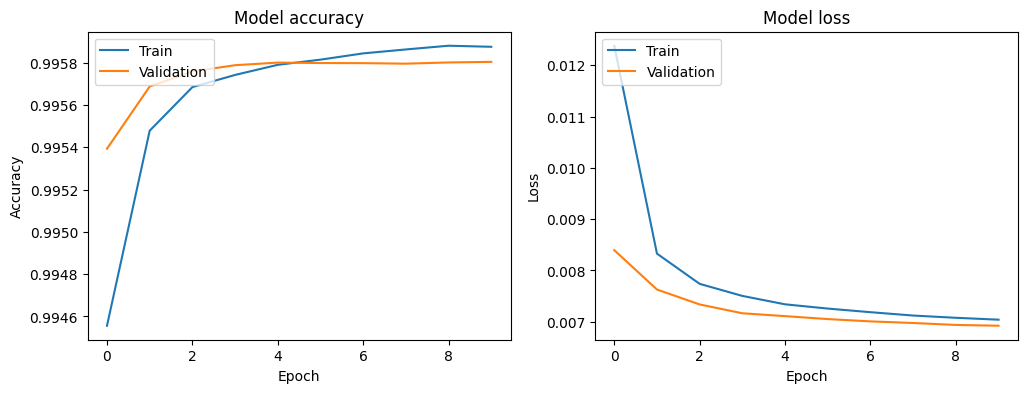

In [245]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [246]:
model_relations.save("model_relations_500k.keras")

# Second Model

In [247]:
from keras.models import Sequential

In [194]:
tags = [
    'O',
    'B-NUMBER', 'I-NUMBER',
    'B-DRINKTYPE', 'I-DRINKTYPE',
    'B-VOLUME', 'I-VOLUME',
    'B-TOPPING', 'I-TOPPING',
    'B-SIZE', 'I-SIZE',
    'B-QUANTITY', 'I-QUANTITY',
    'B-STYLE', 'I-STYLE',
    'B-CONTAINER', 'I-CONTAINER',
    'B-NOT-TOPPING', 'I-NOT-TOPPING',
    'B-NOT-STYLE' , 'I-NOT-STYLE'
]

In [248]:
toppings_regex = re.compile(r'(?<=\(TOPPING\s)[^)]*(?=\s)')
number_regex = re.compile(r'(?<=\(NUMBER\s)[^)]*(?=\s)')
size_regex = re.compile(r'(?<=\(SIZE\s)[^)]*(?=\s)')
quantity_regex = re.compile(r'(?<=\(QUANTITY\s)[^)]*(?=\s)')
style_regex = re.compile(r'(?<=\(STYLE\s)[^)]*(?=\s)')
drink_type_regex = re.compile(r'(?<=\(DRINKTYPE\s)[^)]*(?=\s)')
volume_regex = re.compile(r'(?<=\(VOLUME\s)[^)]*(?=\s)')
container_type_regex = re.compile(r'(?<=\(CONTAINERTYPE\s)[^)]*(?=\s)')   

In [249]:
sizes = set()
toppings = set()
numbers = set()
quantities = set()
styles = set()
drink_types = set()
container_types = set()
volumes = set()


In [250]:
sizes.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: size_regex.findall(x)) for item in sublist])
toppings.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: toppings_regex.findall(x)) for item in sublist])
numbers.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: number_regex.findall(x)) for item in sublist])
quantities.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: quantity_regex.findall(x)) for item in sublist])
styles.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: style_regex.findall(x)) for item in sublist])
drink_types.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: drink_type_regex.findall(x)) for item in sublist])
container_types.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: container_type_regex.findall(x)) for item in sublist])
volumes.update([item.lower() for sublist in df_train['train.TOP'].apply(lambda x: volume_regex.findall(x)) for item in sublist])


In [259]:
def clean_text(text):
    text = re.sub(r"[^\w']", " ", text)  # Remove non-word characters
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces
    text = text.lower().strip()  # Lowercase and strip whitespace
    return text

In [260]:
sizes = list(sizes)
toppings = list(toppings)
numbers = list(numbers)
quantities = list(quantities)
styles = list(styles)
drink_types = list(drink_types)
container_types = list(container_types)
volumes = list(volumes)

In [320]:
sizes = [lemma(size) for size in sizes]
toppings = [lemma(topping) for topping in toppings]
numbers = [lemma(number) for number in numbers]
quantities = [lemma(quantity) for quantity in quantities]
styles = [lemma(style) for style in styles]
drink_types = [lemma(drink_type) for drink_type in drink_types]
container_types = [lemma(container_type) for container_type in container_types]
volumes = [lemma(volume) for volume in volumes]

In [262]:
b_toppings = set()
i_toppings = set()

for topping in toppings:
    topping = topping.split()
    b_toppings.add(topping[0])
    i_toppings.update(topping[1:])

b_toppings = list(b_toppings)
i_toppings = list(i_toppings)


In [263]:
b_styles = set()
i_styles = set()

for style in styles:
    style = style.split()
    style = [word for word in style if word not in {"and", "with",'the'}]
    b_styles.add(style[0])
    i_styles.update(style[1:])

b_styles = list(b_styles)
i_styles = list(i_styles)

In [264]:
b_sizes = set()
i_sizes = set()

for size in sizes:
    size = size.split()
    size = [word for word in size if word not in {'-'}]
    b_sizes.add(size[0])
    i_sizes.update(size[1:])

b_sizes = list(b_sizes)
i_sizes = list(i_sizes)


In [265]:
b_drink_types = set()
i_drink_types = set()

for drink_type in drink_types:
    drink_type = drink_type.split()
    b_drink_types.add(drink_type[0])
    i_drink_types.update(drink_type[1:])

b_drink_types = list(b_drink_types)
i_drink_types = list(i_drink_types)


In [266]:
i_volume = set()

for volume in volumes:
    volume = volume.split('-') 
    if len(volume) == 1:
        volume = volume[0].split()
    
    i_volume.add(volume[1])
    if len(volume) > 2:
        i_volume.update(volume[2:])

i_volume = list(i_volume)
    


In [267]:
quantities = quantities + ['many' , 'more' , 'much' ]


In [268]:
def manual_annotation(text):
    # Break down the text and assign tags manually
    tokens = text.lower().split()
    labels = ['O'] * len(tokens)
    
    negation = False
    
    
    # Identify numbers
    for i, token in enumerate(tokens):
        try:
            token = str(w2n.word_to_num(token))
            labels[i] = 'B-NUMBER'
        except:
            if token == 'a' or token == 'an':
                labels[i] = 'B-NUMBER'
                if token.isdigit():
                    labels[i] = 'B-NUMBER'
    
    # Identify volumes
    for i, token in enumerate(tokens):
        if token in i_volume:
            labels[i-1] = 'B-VOLUME'
            labels[i] = 'I-VOLUME'

    # Identify styles
    for i, token in enumerate(tokens):
        if token in negation_words:
            negation = True
        if token in b_styles:
            labels[i] = 'B-STYLE' if not negation else 'B-NOT-STYLE'
            if i+1 < len(tokens) and tokens[i+1] in i_styles:
                labels[i+1] = 'I-STYLE' if not negation else 'I-NOT-STYLE'
            negation = False
    
    # Identify toppings
    for i, token in enumerate(tokens):
        if token in negation_words:
            negation = True
        elif token in b_toppings:
            labels[i] = 'B-TOPPING' if not negation else 'B-NOT-TOPPING'
            negation = False

    for i, token in enumerate(tokens):
        if token in i_toppings :
            labels[i] = 'I-NOT-TOPPING' if labels[i-1] == 'B-NOT-TOPPING' else 'I-TOPPING' if labels[i-1] == 'B-TOPPING' else labels[i]
    
    # Identify sizes
    for i, token in enumerate(tokens):
        if token in ['sized', 'size']:
            labels[i] = 'I-SIZE'
            labels[i-1] = 'B-SIZE'
        if token in b_sizes:
            labels[i] = 'B-SIZE'

        # Identify drink orders
    for i, token in enumerate(tokens):
        if token in b_drink_types:
            labels[i] = 'B-DRINKTYPE'
            if i+1 < len(tokens) and tokens[i+1] in i_drink_types:
                labels[i+1] = 'I-DRINKTYPE'

    # Identify quantities
    for i, token in enumerate(tokens):
        if token in quantities:
            labels[i] = 'B-QUANTITY'
            if i+1 < len(tokens) and tokens[i+1] in quantities:
                labels[i+1] = 'I-QUANTITY'

    # Identify containers
    for i, token in enumerate(tokens):
        if token in container_types:
            labels[i] = 'B-CONTAINER'
            if i+1 < len(tokens) and tokens[i+1] in container_types:
                labels[i+1] = 'I-CONTAINER'
    
   

                
    return labels

# # Example usage
# text = "five medium pizzas with tomato and ham with no cheese"
# # text = tokenize_adj_noun(text)
# labels = manual_annotation(text)
# print(list(zip(text.split(), labels)))


In [269]:
def generate_training_data(texts):
    labeled_texts = []
    labeled_labels = []
    
    for text in texts:
        # text = tokenize_adj_noun(text)
        labels = manual_annotation(text)
        labeled_texts.append(text)
        labeled_labels.append(" ".join(labels))

    
    return labeled_texts, labeled_labels

In [323]:
X_train, y_train = generate_training_data(df_train['train.SRC'].apply(clean_text).apply(lemma))

In [324]:
input_tokinezer_2 = Tokenizer(oov_token = "<OOV>")
input_tokinezer_2.fit_on_texts(X_train)
X_train = input_tokinezer_2.texts_to_sequences(X_train)

In [325]:
y_train = [y.split() for y in y_train]
y_train = [[tags.index(tag) for tag in y] for y in y_train]

In [326]:
# max_len = max([len(x) for x in X_train])
max_len = MAX_LEN

In [327]:
y_train = pad_sequences(y_train,max_len, padding='post')
X_train = pad_sequences(X_train,max_len, padding='post')

In [328]:
from tensorflow.keras.layers import Embedding,LSTM,Dense,Input,Bidirectional,Attention,Concatenate,TimeDistributed,GRU,SimpleRNN,Convolution1D,Dropout


In [329]:
model = Sequential()
model.add(Embedding(len(input_tokinezer_2.word_index)+1,100))
model.add(Convolution1D(128, 5,padding = 'same' ,activation='relu'))
model.add(Dropout(0.25))
model.add(GRU(100,return_sequences=True))
model.add(TimeDistributed(Dense(len(tags), activation='softmax')))
model.compile('rmsprop', 'sparse_categorical_crossentropy')

In [278]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [330]:
hist = model.fit(X_train, y_train, batch_size=64, epochs=3, validation_split=0.2)

Epoch 1/3
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 318s 50ms/step - loss: 0.0596 - val_loss: 0.0039
Epoch 2/3
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 283s 45ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 3/3
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 318s 51ms/step - loss: 0.0038 - val_loss: 0.0037


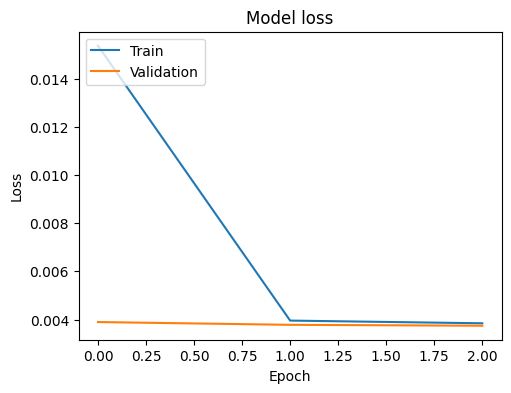

In [331]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [335]:
model.save("model_entity_500k.keras")

In [368]:
def setToppings(token, tokens, i,entity_preds):
    quantity = None
    temp = ""
    not_flag = False
    while("TOPPING" in entity_preds[i] or "QUANTITY" in entity_preds[i]):
        if "NOT" in entity_preds[i]:
            not_flag = True
            temp += " " + tokens[i]
        elif "QUANTITY" in entity_preds[i]:
            quantity = tokens[i]
        else :
            temp += " "  + tokens[i]
        i+=1
        
    if temp == "":
        topping = None
    
    else : 
        topping = {
        "NOT": not_flag,
        "Quantity": quantity,
        "Topping": temp
    }
    return topping,i-1

In [367]:
def setStyle (token, tokens, i,entity_preds):
    temp = ""
    not_flag = False
    while("STYLE" in entity_preds[i]):
        if "NOT" in entity_preds[i]:
            not_flag = True
            temp += " " + tokens[i]
        else:
            temp += " "  + tokens[i]
        i+=1

    style = {
        "NOT": not_flag,
        "TYPE": temp
    }
    return style,i-1

In [366]:
def get_pizza_order(relations_preds,tokens,entity_preds,i):
    current_order = {"NUMBER": None, "SIZE": None, "STYLE": [], "AllTopping": []}
    temp_i = i
    while(i < len(tokens) and (temp_i == i or relations_preds[i] == 'I-Pizza' or relations_preds[i] == 'O' )):
        if entity_preds[i] == "B-TOPPING" or entity_preds[i] == "B-NOT-TOPPING" or (entity_preds[i] == "B-QUANTITY" and i+1 < len(entity_preds) and entity_preds[i+1] == "B-TOPPING"):
            topping,i= setToppings(tokens[i], tokens, i,entity_preds )
            if topping is not None:
                current_order["AllTopping"].append(topping)

        elif entity_preds[i] == "B-NUMBER":
            current_order["NUMBER"] = tokens[i]
        elif entity_preds[i] == "B-SIZE":
            if entity_preds[i-1] == "B-QUANTITY":
                current_order["SIZE"] = tokens[i-1] + " " + tokens[i]
            else:
                current_order["SIZE"] = tokens[i]
        
        elif "STYLE" in entity_preds[i]:
            s,i = setStyle(tokens[i], tokens, i,entity_preds)
            current_order["STYLE"].append(s)
        i += 1
    return current_order,i


In [288]:
def setDrink(token, tokens, i,entity_preds):
    temp = ""
    while(token in entity_preds[i]):
        temp += " "  + tokens[i]
        i+=1
    return temp,i-1

In [289]:
def get_drink_order(relations_preds,tokens,entity_preds,i):
    current_order = {"NUMBER": None, "DRINKTYPE": None, "VOLUME": None, "CONTAINER": None,"SIZE": None}
    temp_i = i
    while( i < len(tokens) and (temp_i == i or relations_preds[i] == 'I-Drink' or relations_preds[i] == 'O')):
        # if "B-DRINKTYPE" in entity_preds[i]:
            # current_order["DRINKTYPE"],i = setDrink("DRINKTYPE", tokens, i,entity_preds)
        if entity_preds[i] == "B-NUMBER":
            current_order["NUMBER"] = tokens[i]
        elif "VOLUME" in entity_preds[i]:
            current_order["VOLUME"],i = setDrink("VOLUME", tokens, i,entity_preds)
        elif "CONTAINER" in entity_preds[i]:
            current_order["CONTAINER"],i = setDrink("CONTAINER" , tokens, i,entity_preds)
        elif "SIZE" in entity_preds[i]:
            current_order["SIZE"],i = setDrink("SIZE" , tokens, i,entity_preds)
        elif entity_preds[i] != 'O': 
            current_order["DRINKTYPE"] = tokens[i]

        i += 1
    return current_order,i

In [421]:
def parse_order(input_text, relations_preds, entity_preds):
    tokens = input_text.split()

    # Combine predictions with tokens
    combined = [
        {"token": token, "model1": m1, "model2": m2}
        for token, m1, m2 in zip(tokens, relations_preds, entity_preds)
    ]

    pizza_orders = []
    drink_orders = []
    current_order = None

    for i, item in enumerate(combined):
        token, model1, model2 = item["token"], item["model1"], item["model2"]

        if model1 == "B-Pizza":
            # Start a new order
            current_order , i = get_pizza_order(relations_preds,tokens,entity_preds,i)
            if len(current_order["AllTopping"]) == 0 and current_order["SIZE"] is None and current_order["NUMBER"] is None and len(current_order["STYLE"]) == 0:
                continue
            if current_order["NUMBER"] is None:
                current_order["NUMBER"] = "a"
            pizza_orders.append(current_order)


        elif model1 == "B-Drink":
            current_order , i = get_drink_order(relations_preds,tokens,entity_preds,i)
            drink_orders.append(current_order)

        elif model1 == "I-Pizza" and current_order is None: 
            current_order , i = get_pizza_order(relations_preds,tokens,entity_preds,i)
            if len(current_order["AllTopping"]) == 0 and current_order["SIZE"] is None and current_order["NUMBER"] is None and len(current_order["STYLE"]) == 0:
                continue
            if current_order["NUMBER"] is None:
                current_order["NUMBER"] = "a"
            pizza_orders.append(current_order)



    # Construct final output
    output = {"ORDER": {"PIZZAORDER": pizza_orders, "DRINKORDER": drink_orders}}
    return output

# # Example input
# input_text = x_test
# relations_preds = pred_relation
# entity_preds = pred_entity

# print(input_text)
# print(relations_preds)
# print(entity_preds)

# # Parse
# output = parse_order(input_text, relations_preds, entity_preds)
# output

In [291]:
x_dev = df_dev['dev.SRC']

In [485]:
import json

for i,x in enumerate(x_dev):
    x_test = clean_text(x)
    x_test = expnad_abb2(x_test)
    x_test = remove_stopwords(x_test)
    x_test = lemma(x_test)
    x_test_relation = input_tokinezer.texts_to_sequences([x_test])
    x_test_relation = pad_sequences(x_test_relation, maxlen=max_length, padding='post')
    pred_relation = model_relations.predict(x_test_relation)
    pred_relation = np.argmax(pred_relation, axis=-1)
    pred_relation = [list(relation_tags.keys())[list(relation_tags.values()).index(i)] for i in pred_relation[0]]
    x_test_entity = input_tokinezer_2.texts_to_sequences([x_test])
    x_test_entity = pad_sequences(x_test_entity, maxlen=max_len, padding='post')

    pred_entity = model.predict(x_test_entity)
    pred_entity = np.argmax(pred_entity, axis=-1)
    pred_entity = [tags[i] for i in pred_entity[0]]
    output = parse_order(x_test, pred_relation, pred_entity)
    with open("results/output{}.json".format(i), "a") as f:
        json.dump(output, f, indent=4)
        

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

In [436]:
print(x_test)
print(pred_relation)
print(pred_entity)

put a med peto sauce and ham a large iced tea bottle
['O', 'B-Pizza', 'I-Pizza', 'O', 'I-Pizza', 'I-Pizza', 'O', 'B-Drink', 'I-Drink', 'I-Drink', 'I-Drink', 'I-Drink', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['B-SIZE', 'B-NUMBER', 'B-STYLE', 'B-TOPPING', 'I-TOPPING', 'O', 'B-TOPPING', 'B-NUMBER', 'B-SIZE', 'B-TOPPING', 'I-DRINKTYPE', 'B-CONTAINER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [437]:
output

{'ORDER': {'PIZZAORDER': [{'NUMBER': 'a',
    'SIZE': None,
    'STYLE': [{'NOT': False, 'TYPE': ' med'}],
    'AllTopping': [{'NOT': False, 'Quantity': None, 'Topping': ' peto sauce'},
     {'NOT': False, 'Quantity': None, 'Topping': ' ham'}]}],
  'DRINKORDER': [{'NUMBER': 'a',
    'DRINKTYPE': 'tea',
    'VOLUME': None,
    'CONTAINER': ' bottle',
    'SIZE': ' large'}]}}

In [358]:
df_test = pd.read_csv("E:/Collage/NLP/Project/testdata/test_set.csv")
df_test

,id,order
0,0,let me prefer a extra large sauteed spinach an...
1,1,could you give me a exta large pizza with roas...
2,2,can you handle this order a pizza make it etra...
3,3,let me try 5 lnch pizzas with garlic onions an...
4,4,i need you to order me a pie in med size along...
...,...,...
3995,3995,i'd have medium pizza along with thin crust ol...
3996,3996,i want a chicken and pepperoni pie with extra ...
3997,3997,get me a sausage pizza with extra cheese and n...
3998,3998,i'd like a large pepperoni pizza with extra ch...


In [496]:
df_test_copy = df_test.copy()

In [497]:
df_test_copy ['order'] = df_test_copy['order'].apply(lambda x: clean_text(x)).apply(lambda x: expnad_abb2(x)).apply(lambda x: remove_stopwords(x)).apply(lambda x: lemma(x))

In [ ]:
import json

for i,x in enumerate(df_test_copy['order']):
    # x_test = clean_text(x)
    # # print(x_test)
    # x_test = expnad_abb2(x_test)
    # # print(x_test)
    # x_test = remove_stopwords(x_test)
    # print(x_test)
    x_test = x
    # print(x_test)
    x_test_relation = input_tokinezer.texts_to_sequences([x_test])
    x_test_relation = pad_sequences(x_test_relation, maxlen=max_length, padding='post')
    pred_relation = model_relations.predict(x_test_relation)
    pred_relation = np.argmax(pred_relation, axis=-1)
    pred_relation = [list(relation_tags.keys())[list(relation_tags.values()).index(i)] for i in pred_relation[0]]
    x_test_entity = input_tokinezer_2.texts_to_sequences([x_test])
    # print(input_tokinezer_2.sequences_to_texts(x_test_entity))
    x_test_entity = pad_sequences(x_test_entity, maxlen=max_len, padding='post')

    pred_entity = model.predict(x_test_entity)
    pred_entity = np.argmax(pred_entity, axis=-1)
    pred_entity = [tags[i] for i in pred_entity[0]]
    output = parse_order(x_test, pred_relation, pred_entity)
    # print(pred_relation)
    # print(pred_entity)
    with open("results_test/output{}.json".format(i), "a") as f:
        json.dump(output, f, indent=4)
        

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
['O', 'B-Pizza', 'I-Drink', 'O', 'O', 'I-Pizza', 'O', 'I-Pizza', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['B-NUMBER', 'B-DRINKTYPE', 'B-DRINKTYPE', 'B-TOPPING', 'O', 'B-TOPPING', 'O', 'O', 'B-NOT-TOPPING', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [499]:
output

{'ORDER': {'PIZZAORDER': [], 'DRINKORDER': []}}